In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from scipy.stats import norm
from numpy.polynomial import legendre
import pandas as pd

In [2]:
def elliptical_sampling(f,Sigma,logL,points_inhomo,num): ## f is initial vector, Sigma is the covariance in the prior, logL is LogL, num is the number of samples you want
    assert len(f)==len(np.diagonal(Sigma))
    D=len(f)
    i=0
    samples=[]
    
    while(i<num):
        v=multivariate_normal.rvs(np.zeros(D),Sigma)
        u=uniform.rvs(0,1)
        logy=logL(points_inhomo,xi,f,theta0,theta1,p,T)+np.log(u)
        theta=uniform.rvs(0,2*np.pi)
        theta_min=theta-2*np.pi
        theta_max=theta
        while(1):
            f_new=f*np.cos(theta)+v*np.sin(theta)
            if logL(points_inhomo,xi,f_new,theta0,theta1,p,T)>logy:
                samples.append(f_new)
                i+=1
                f=f_new
                break
            else:
                if theta<0:
                    theta_min=theta
                else:
                    theta_max=theta
                theta=uniform.rvs(theta_min,theta_max)
    return np.array(samples)

In [3]:
T=100

## simulation

In [3]:
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [4]:
def GP_regression(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(cov_K.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points],mean, posterior_cov

In [559]:
theta0=0.1

In [560]:
theta1=0.01

In [561]:
xi=np.linspace(T/10/2,T-T/10/2,10)   # 10 inducing points

In [562]:
def u_generate(theta0,theta1,xi): # xi is inducing points, N(0,Sigma)
    N=len(xi)
    cov=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov[j][i]=cov[i][j]
    return multivariate_normal([0]*N,cov).rvs(),np.array([0]*N),cov

In [563]:
u,mean_p_u,cov_p_u=u_generate(theta0,theta1,xi)

In [11]:
f=GP_regression(xi,u,theta0,theta1,0.0001,T,1000) # f is 1000-dimension vector on [0,T]

In [12]:
f_1=multivariate_normal(f[1],f[2]).rvs() # f sample

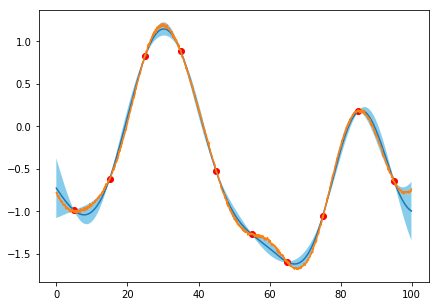

In [13]:
plt.figure(1,figsize=(7,5))
axs=plt.subplot(111)
axs.plot(xi,u,'ro')
axs.plot(f[0],f[1])
axs.fill_between(f[0],f[1]-np.sqrt(np.diagonal(f[2])),f[1]+np.sqrt(np.diagonal(f[2])),facecolor=(0.53,0.8,0.92))
axs.plot(f[0],f_1)
plt.show()

In [14]:
lamda=np.exp(f_1)

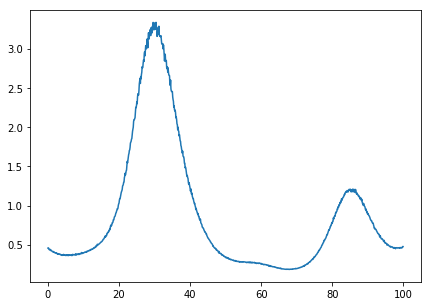

In [15]:
plt.figure(1,figsize=(7,5))
axs=plt.subplot(111)
axs.plot(f[0],lamda)
plt.show()

In [16]:
def inhomo_simulation(measure,delta_t,measure_sup,T):
    t=0
    points_homo=[]
    points_inhomo=[]
    while(t<T):
        points_homo.append(t)
        r=expon.rvs(scale=1/measure_sup) #scale=1/lamda
        t+=r
        if t>=T: break
        D=uniform.rvs(loc=0,scale=1)
        if D*measure_sup<=measure[int(t/delta_t)]:
            points_inhomo.append(t)
    if points_inhomo[-1]>T:
        del points_inhomo[-1]
    del points_homo[0]
    return points_inhomo

In [17]:
points_inhomo=inhomo_simulation(lamda,0.1,max(lamda),T)

In [18]:
len(points_inhomo)

85

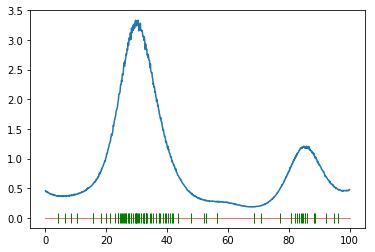

In [19]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot([0,T],[0,0],'r-',lw=1,alpha=0.6)
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10)
plt.plot(f[0],lamda)
plt.show()

In [526]:
rawdata = pd.read_excel("./NYPD_Motor_Vehicle_Collisions.xlsx")

In [527]:
df=rawdata.loc[:,['DATE','TIME']]

In [528]:
df['DATE']=pd.to_datetime(df['DATE'])

In [529]:
training=[]

In [536]:
start=np.datetime64('2017-10-09')       # June, July, August
end=np.datetime64('2017-10-13')
interval = pd.date_range(start, end)

In [537]:
for i in interval:
    df_1=df[df['DATE']==i]

    df_1['ts']=df_1.apply(lambda r : pd.datetime.combine(r['DATE'],r['TIME']),1)

    df_1['ts']=df_1['ts'].astype(np.int64)

    df_1=df_1.sort_values(['ts'])

    training_data=df_1['ts'].values/1000000000  # convert to second

    training_data=training_data-training_data[0]+1

    training_data=training_data/60      # convert to minite, T=1440
    training_data=training_data/10      # convert to 10 minite, T=144
    
    for i in range(20):                 # delete points at 0
        if training_data[0]==training_data[1]:
            training_data=np.delete(training_data,1)
            
    for i in range(1,len(training_data)):  # divide points at same time
        for j in range(i):
            if training_data[j]==training_data[i]:
                training_data[i]+=0.01

    training.append(list(training_data))

C:\Users\zho045\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\zho045\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [539]:
len(training)

17

In [556]:
del training[16][:10]

In [557]:
len(training[3])

512

In [558]:
T=144

## MCMC inference

In [564]:
cov_p_u_inv=np.linalg.inv(cov_p_u)

In [565]:
def mean(s,xi,yi,cov_p_u_inv,theta0,theta1): ## knowing inducing points to predict mean at s (single point)
    N=len(xi)
    k_vec=np.array([])
    for i in range(N):
        k_vec=np.append(k_vec,expo_quad_kernel(theta0,theta1,s,xi[i]))
    mean=np.matmul(np.matmul(k_vec,cov_p_u_inv),yi)
    return mean

In [566]:
def sigma(s1,s2,xi,cov_p_u_inv,theta0,theta1): ## knowing inducing points to predict variance(cov) at s1, s2
    N=len(xi)
    if s1==s2:
        sigma_s1_s2=theta0
        k_s1=np.array([])
        for i in range(N):
            k_s1=np.append(k_s1,expo_quad_kernel(theta0,theta1,s1,xi[i]))
        k_s2=k_s1
    else:
        sigma_s1_s2=expo_quad_kernel(theta0,theta1,s1,s2)
        k_s1=np.array([])
        k_s2=np.array([])
        for i in range(N):
            k_s1=np.append(k_s1,expo_quad_kernel(theta0,theta1,s1,xi[i]))
            k_s2=np.append(k_s2,expo_quad_kernel(theta0,theta1,s2,xi[i]))
    var=sigma_s1_s2-np.matmul(np.matmul(k_s1,cov_p_u_inv),k_s2.T)
    return var

In [567]:
def gq_points_weights(a,b,Q):
    p,w=np.polynomial.legendre.leggauss(Q)
    c = np.array([0]*Q + [1])
    p_new=(a+b+(b-a)*p)/2
    w_new=(b-a)/(legendre.legval(p, legendre.legder(c))**2*(1-p**2))
    return p_new,w_new

In [568]:
def logL(points_inhomo,xi,yi,theta0,theta1,p,T):
    p_gq,w_gq=gq_points_weights(0,T,p)
    m_gq=np.zeros(p)
    sigma_gq=np.zeros((p,p))
    for i in range(p):
        m_gq[i]=mean(p_gq[i],xi,yi,cov_p_u_inv,theta0,theta1)
    for i in range(p):
        for j in range(i,p):
            sigma_gq[i][j]=sigma(p_gq[i],p_gq[j],xi,cov_p_u_inv,theta0,theta1)
            sigma_gq[j][i]=sigma_gq[i][j]
    mu_I=np.exp(m_gq+0.5*np.diagonal(sigma_gq)).dot(w_gq)
    sigma_I=0
    for i in range(p):
        for j in range(p):
            sigma_I+=w_gq[i]*w_gq[j]*np.exp(m_gq[i]+m_gq[j]+sigma_gq[i][j]+0.5*sigma_gq[i][i]+0.5*sigma_gq[j][j])
    sigma_I-=mu_I**2
    assert sigma_I>0
    alpha_I=mu_I**2/sigma_I
    beta_I=sigma_I/mu_I
    
    N=len(points_inhomo)
    M=np.zeros(N)
    Sigma_diag=np.zeros(N)
    for i in range(N):
        M[i]=mean(points_inhomo[i],xi,yi,cov_p_u_inv,theta0,theta1)
        Sigma_diag[i]=sigma(points_inhomo[i],points_inhomo[i],xi,cov_p_u_inv,theta0,theta1)
    logl=sum(M)+0.5*sum(Sigma_diag)-alpha_I*np.log(1+beta_I)
    return logl

In [569]:
p=20

In [27]:
sample=elliptical_sampling(np.zeros(len(xi)),cov_p_u,logL,points_inhomo,500)

In [30]:
yy=[]
for i in range(100):
    xxx,yyy=GP_predict(xi,sample[-1-i],theta0,theta1,0,T,100)
    yy.append(yyy)
yy=np.exp(np.average(np.array(yy),axis=0))

In [40]:
sum(yy*1)

99.83206624987463

In [41]:
len(points_inhomo)

85

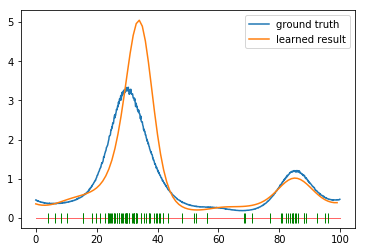

In [39]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot([0,T],[0,0],'r-',lw=1,alpha=0.6)
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10)
plt.plot(f[0],lamda,label='ground truth')
plt.plot(xxx,yy,label='learned result')
plt.legend()
plt.show()

In [570]:
def GP_predict(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(cov_K.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points], mean+np.diagonal(posterior_cov)

In [595]:
samples=[]
for i in range(12):
    sample=elliptical_sampling(np.zeros(len(xi)),cov_p_u,logL,training[i],300)
    samples.append(sample)

In [596]:
y=[]
for j in range(len(samples)):
    yy=[]
    for i in range(100):
        xxx,yyy=GP_predict(xi,samples[j][-1-i],theta0,theta1,0,T,100)
        yy.append(yyy)
    yy=np.exp(np.average(np.array(yy),axis=0))
    y.append(yy)

In [597]:
y_ave=np.average(y,axis=0)

In [598]:
sum(y_ave*(T/len(y_ave)))

526.1744936241382

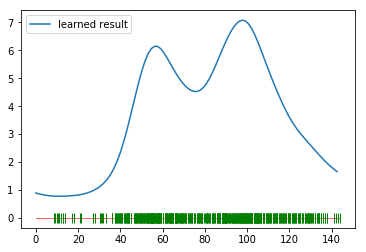

In [599]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot([0,T],[0,0],'r-',lw=1,alpha=0.6)
plt.plot(training[0],np.zeros(len(training[0])),linestyle='None', marker='|', color='g', markersize=10)
# plt.plot(f[0],lamda,label='ground truth')
plt.plot(xxx,y_ave,label='learned result')
plt.legend()
plt.show()

In [600]:
def loglikelihood(lamda,points_poisson,T):  ## discrete lamda
    N=len(lamda)
    M=len(points_poisson)
    delta_t=T/N
    logL=0
    for i in range(M):
        logL+=np.log(lamda[int(points_poisson[i]/delta_t)])
    logL-=sum(lamda*delta_t)
    return logL

## 1 training sequence

In [577]:
logL_test=[]
for i in range(12,17):
    logL_test.append(loglikelihood(y_ave,training[i],T))

In [578]:
np.average(logL_test)

338.1254311462561

## 5 training sequence

In [585]:
logL_test=[]
for i in range(12,17):
    logL_test.append(loglikelihood(y_ave,training[i],T))

In [586]:
np.average(logL_test)

368.360927071888

## 9 training sequence

In [593]:
logL_test=[]
for i in range(12,17):
    logL_test.append(loglikelihood(y_ave,training[i],T))

In [594]:
np.average(logL_test)

375.3386427787671

## 12 training sequence

In [601]:
logL_test=[]
for i in range(12,17):
    logL_test.append(loglikelihood(y_ave,training[i],T))

In [602]:
np.average(logL_test)

376.13760371075625

In [603]:
y_ave

array([0.89007704, 0.86294998, 0.83826827, 0.8171089 , 0.80020691,
       0.78787569, 0.78000316, 0.7761269 , 0.77557848, 0.77767234,
       0.78189973, 0.78807955, 0.79642678, 0.80752518, 0.82222584,
       0.84151925, 0.86643684, 0.89802693, 0.93742781, 0.98603441,
       1.04573031, 1.11913704, 1.20982078, 1.3223926 , 1.46243797,
       1.63620888, 1.85001169, 2.10924827, 2.41714858, 2.77338049,
       3.1728864 , 3.60536291, 4.05566305, 4.50508272, 4.93317875,
       5.3196772 , 5.64621632, 5.89794012, 6.06504529, 6.14418573,
       6.13931766, 6.06144061, 5.92695459, 5.75491248, 5.56395073,
       5.36980902, 5.18405529, 5.01413447, 4.86442466, 4.73775664,
       4.63683536, 4.56514212, 4.52712615, 4.52773127, 4.57146776,
       4.66129597, 4.79757144, 4.97727786, 5.19377021, 5.43721202,
       5.6957298 , 5.95701319, 6.20980313, 6.44466007, 6.65371336,
       6.82963456, 6.96454668, 7.04970224, 7.07643963, 7.03827709,
       6.93331891, 6.76581403, 6.54598803, 6.28807104, 6.00729

In [607]:
rawdata = pd.read_csv("./2016_Green_Taxi_Trip_Data.csv")

In [608]:
date_series=['01/02/2016','01/03/2016','01/04/2016','01/05/2016','01/06/2016','01/07/2016','01/08/2016','01/09/2016',
            '01/10/2016','01/11/2016','01/12/2016','01/13/2016','01/14/2016','01/15/2016','01/16/2016',
            '01/17/2016','01/18/2016','01/19/2016','01/20/2016','01/21/2016','01/22/2016','01/23/2016',
            '01/24/2016','01/25/2016','01/26/2016','01/27/2016','01/28/2016','01/29/2016','01/30/2016','01/31/2016','02/01/2016']

In [609]:
def training_data_extraction(N):
    training_data=[]
    for i in range(N):
        df_1=rawdata[(rawdata['lpep_pickup_datetime']<date_series[i+1]) & (rawdata['lpep_pickup_datetime']>date_series[i])]
        
        origin=pd.to_datetime(date_series[i]).value/10**9/600 # convert to 10 minute

        df_1=df_1[df_1['Trip_distance']>15]

        df_1=df_1[['lpep_pickup_datetime']]

        df_1['lpep_pickup_datetime']=pd.to_datetime(df_1['lpep_pickup_datetime'])

        df_1['lpep_pickup_datetime']=df_1['lpep_pickup_datetime'].astype(np.int64)

        df_1=df_1.sort_values(['lpep_pickup_datetime'])
        training_data_1=df_1['lpep_pickup_datetime'].values/(10**9) # convert to second
        training_data_1=training_data_1/600 # convert to 10 minute
        training_data_1=training_data_1-origin
        training_data_1=np.unique(training_data_1)
        training_data.append(training_data_1)
    return training_data

In [610]:
training=training_data_extraction(30)

In [611]:
np.average([len(training[i]) for i in range(30)])

368.26666666666665

In [612]:
samples=[]
for i in range(5,10):
    sample=elliptical_sampling(np.zeros(len(xi)),cov_p_u,logL,training[i],300)
    samples.append(sample)

In [613]:
y=[]
for j in range(len(samples)):
    yy=[]
    for i in range(100):
        xxx,yyy=GP_predict(xi,samples[j][-1-i],theta0,theta1,0,T,100)
        yy.append(yyy)
    yy=np.exp(np.average(np.array(yy),axis=0))
    y.append(yy)

In [614]:
y_ave=np.average(y,axis=0)

In [615]:
sum(y_ave*(T/len(y_ave)))

344.33353159361656

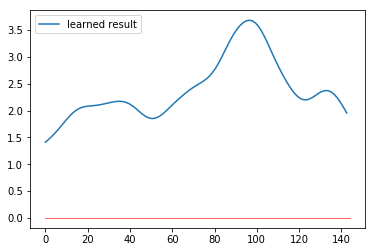

In [616]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot([0,T],[0,0],'r-',lw=1,alpha=0.6)
# plt.plot(training[0],np.zeros(len(training[0])),linestyle='None', marker='|', color='g', markersize=10)
plt.plot(xxx,y_ave,label='learned result')
plt.legend()
plt.show()

In [617]:
y_ave

array([1.410974  , 1.45928756, 1.51238729, 1.57048711, 1.63334792,
       1.69999599, 1.76853657, 1.83617822, 1.89955111, 1.95530993,
       2.00087884, 2.03508884, 2.05845647, 2.07298682, 2.08158484,
       2.08731097, 2.09273951, 2.09958374, 2.10861252, 2.11977479,
       2.13240694, 2.14542078, 2.15742492, 2.16678378, 2.17165326,
       2.17005683, 2.16007941, 2.14023394, 2.10997279, 2.07019632,
       2.02352978, 1.97417937, 1.92734147, 1.88833117, 1.86169375,
       1.85052068, 1.85607366, 1.87772309, 1.9131756 , 1.95896524,
       2.011152  , 2.06608999, 2.12104749, 2.17446971, 2.22580762,
       2.27503244, 2.32210009, 2.36664672, 2.40808203, 2.44605628,
       2.48108878, 2.51504424, 2.55118792, 2.59372474, 2.64693609,
       2.7141621 , 2.79690022, 2.89424472, 3.00282692, 3.11732915,
       3.23149633, 3.33936467, 3.4362714 , 3.51924637, 3.58665412,
       3.63732462, 3.66967014, 3.68129651, 3.66938035, 3.63170636,
       3.56790221, 3.48025571, 3.37366385, 3.25468487, 3.13009

## 1 training sequence

In [495]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(y_ave,training[i],T))

In [496]:
np.average(logL_test)

16.92176401778272

## 5 training sequence

In [502]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(y_ave,training[i],T))

In [503]:
np.average(logL_test)

13.261230915452085

## 10 training sequence

In [509]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(y_ave,training[i],T))

In [510]:
np.average(logL_test)

17.535336500660197

## 15 training sequence

In [516]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(y_ave,training[i],T))

In [517]:
np.average(logL_test)

15.099386985848549

## 20 training sequence

In [523]:
logL_test=[]
for i in range(5):
    logL_test.append(loglikelihood(y_ave,training[i],T))

In [524]:
np.average(logL_test)

14.12449126239908